In [2]:
import requests
import nltk
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import json
nlp = spacy.load('en_core_web_sm')
from tqdm.auto import tqdm
from textblob import TextBlob

In [15]:
!pip install plotly
!pip install pyyaml==5.4.1
!pip install vaderSentiment
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.4 MB/s 
     |████████████████████████████████| 1.6 MB 48.3 MB/s 
     |████████████████████████████████| 4.2 MB 31.7 MB/s 
     |████████████████████████████████| 19.7 MB 356 kB/s 
     |████████████████████████████████| 981 kB 46.6 MB/s 
     |████████████████████████████████| 1.2 MB 45.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 788 kB 40.1 MB/s 
     |█████████████████████████

In [4]:
r = requests.get('https://www.aljazeera.com/where/mozambique/')
r.encoding = 'utf-8'
page = r.content


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
soup = BeautifulSoup(page, 'html5lib')
articles_scraped = soup.find_all('h3', class_='gc__title')
articles_scraped[1].find('a')['href']
n = 10
article_contents = []
list_links = []
list_titles = []
result = []
#Using the tqdm package to track the progress of the web scraping+sentiment analysis
for n in tqdm(range(n)):
    
    link = articles_scraped[n].find('a')['href']
    list_links.append("https://www.aljazeera.com"+link)
    # print(list_links)
    title = articles_scraped[n].find('a').get_text()
    list_titles.append(title)
    article = requests.get("https://www.aljazeera.com"+link)
    article_content = article.content
    soup_article = BeautifulSoup(article_content, 'html5lib')
    for a in soup_article.findAll('a', href=True):
        a.extract()
    body = soup_article.find_all('div',{"class":['wysiwyg wysiwyg--all-content css-1ck9wyi','wysiwyg wysiwyg--all-content css-1b98pzi']})
    x = body[0].find_all('p')

    
  # Method Purpose: Given an average polarity or subjectivity, uses intervals to calculate accurate sentiments.
  # Note: Polarity and Subjectivity in TextBlob fall in between -1 and 1, this method bases its intervals off of that.
    def calculate_sentiment(sentiment, type):
        sentiment_category = ""
        if type == "polarity":
            if sentiment > 0.75:
                sentiment_category = "Extremely positive."
            elif sentiment > 0.5:
                sentiment_category = "Significantly positive."
            elif sentiment > 0.3:
                sentiment_category = "Fairly positive."
            elif sentiment > 0.1:
                sentiment_category = "Slightly positive."
            elif sentiment < -0.1:
                sentiment_category = "Slightly negative."
            elif sentiment < -0.3:
                sentiment_category = "Fairly negative."
            elif sentiment < -0.5:
                sentiment_category = "Significantly negative."
            elif sentiment < -0.75:
                sentiment_category = "Extremely negative."
            else:
                sentiment_category = "Neutral."
            return sentiment_category
        elif type == "subjectivity":
            if sentiment > 0.75:
                sentiment_category = "Extremely subjective."
            elif sentiment > 0.5:
                sentiment_category = "Fairly subjective."
            elif sentiment > 0.3:
                sentiment_category = "Fairly objective."
            elif sentiment > 0.1:
                sentiment_category = "Extremely objective."
            return sentiment_category
        else:
            print("Invalid Input.")
      
    def calculate_average(list):
        return sum(list) / len(list)
    
    list_paragraphs = []
    for p in np.arange(0, len(x)):
        paragraph = x[p].get_text()
        list_paragraphs.append(paragraph)
        final_article = " ".join(list_paragraphs)
    final_article = final_article.replace("\n"," ")
    final_article = final_article.replace("\t","")
    final_article = final_article.replace("\xa0","")  
    final_article= ''.join([c for c in final_article if c != "'"])
    article_contents.append(final_article)
    articles = TextBlob(final_article)
    # Iterates over each sentence in the article, extracts the sentiment, and stores each inside of a list.
    sentiments = []
    for sentence in articles.sentences:
        sentiment = sentence.sentiment
        for metric in sentiment:
            sentiments.append(metric)

    # Every even index in the list corresponds to polarity and the rest relate to subjectivity.
    # Using this, the polarity_data and subjectivity_data lists are filled accurately.
    polarity_data = []
    subjectivity_data = []
    textblob_sentiment=[]
    for i in range(len(sentiments)):
        if i % 2 == 0:
            polarity_data.append(sentiments[i])
        else:
            subjectivity_data.append(sentiments[i])

    # The averages of both sentiment lists are calculated.
    polarity_average = calculate_average(polarity_data)
    subjectivity_average = calculate_average(subjectivity_data)
    textblob_sentiment.append([polarity_average,subjectivity_average])

    # Displays the sentiment that relates to the averages on the console.
    print()
    print("Analysis of Article")
    polarity = calculate_sentiment(polarity_average, "polarity")
    subjectivity = calculate_sentiment(subjectivity_average, "subjectivity")
    result.append(calculate_sentiment(polarity_average, "polarity"))
    print("Polarity of the article:" + polarity)
    print("Subjectivity of the article:" + subjectivity)

    df_textblob = pd.DataFrame(textblob_sentiment, columns =['Polarity', 'Subjectivity'])
    print(df_textblob.head())  

  0%|          | 0/10 [00:00<?, ?it/s]


Analysis of Article
Polarity of the article:Neutral.
Subjectivity of the article:Extremely objective.
   Polarity  Subjectivity
0  0.093229      0.298385

Analysis of Article
Polarity of the article:Slightly negative.
Subjectivity of the article:Extremely objective.
   Polarity  Subjectivity
0 -0.108819      0.245139

Analysis of Article
Polarity of the article:Neutral.
Subjectivity of the article:Fairly objective.
   Polarity  Subjectivity
0  0.066335      0.351847

Analysis of Article
Polarity of the article:Neutral.
Subjectivity of the article:Fairly objective.
   Polarity  Subjectivity
0  0.054588      0.318925

Analysis of Article
Polarity of the article:Neutral.
Subjectivity of the article:Extremely objective.
   Polarity  Subjectivity
0  0.026316      0.228728

Analysis of Article
Polarity of the article:Slightly positive.
Subjectivity of the article:Fairly objective.
   Polarity  Subjectivity
0   0.12197      0.301515

Analysis of Article
Polarity of the article:Slightly negat

In [7]:
#Visualization Using Plotly library
df_result=pd.DataFrame({'Analysis':result, 'Article Title':list_titles})


import plotly.express as px
 
fig1 = px.scatter(df_result, x="Article Title", y="Analysis", marginal_y="rug", title="Sentiment Analysis of the Articles")
fig2 = px.bar(df_result, x="Article Title", y="Analysis", color="Analysis", title="Sentiment Analysis of the Articles")
fig1.show()
fig2.show()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [8]:
df_result

,Analysis,Article Title
0,Neutral.,Floods hit South Africa’s KwaZu­lu-Na­tal prov...
1,Slightly negative.,Mozam­bique: Cy­clone Gombe death toll ris­es ...
2,Neutral.,Mozam­bique an­nounces new prime min­is­ter af...
3,Neutral.,Analy­sis: Can African gas re­place Russ­ian s...
4,Neutral.,Dozens dead from Trop­i­cal Storm Ana in south...
5,Slightly positive.,South­ern Africa bloc SADC ex­tends Mozam­biqu...
6,Slightly negative.,Cli­mate change and famine | Start Here
7,Neutral.,"In Mozam­bique, Kagame says Rwan­dan troops’ w..."
8,Slightly positive.,"Rwan­da, Mozam­bique forces re­cap­ture port c..."
9,Neutral.,"Rwan­da de­ploys 1,000 sol­diers to Mozam­biqu..."


In [9]:
import pandas as pd
article_df = pd.DataFrame(
        {'Title':list_titles, 'Content':article_contents, 'Link':list_links,
})

In [10]:
article_df

,Title,Content,Link
0,Floods hit South Africa’s KwaZu­lu-Na­tal prov...,Heavy rains in South Africa have forced hundre...,https://www.aljazeera.com/news/2022/5/23/flood...
1,Mozam­bique: Cy­clone Gombe death toll ris­es ...,Tropical Cyclone Gombe has killed at least 53 ...,https://www.aljazeera.com/news/2022/3/18/mozam...
2,Mozam­bique an­nounces new prime min­is­ter af...,Mozambique President Filipe Nyusi has appointe...,https://www.aljazeera.com/news/2022/3/4/mozamb...
3,Analy­sis: Can African gas re­place Russ­ian s...,"Lagos, Nigeria – On February 22, German Chance...",https://www.aljazeera.com/economy/2022/3/1/ana...
4,Dozens dead from Trop­i­cal Storm Ana in south...,The death toll from a storm that struck three ...,https://www.aljazeera.com/news/2022/1/27/at-le...
5,South­ern Africa bloc SADC ex­tends Mozam­biqu...,Southern African regional bloc SADC at a summi...,https://www.aljazeera.com/news/2022/1/12/south...
6,Cli­mate change and famine | Start Here,Madagascar is on the brink of famine because o...,https://www.aljazeera.com/program/start-here/2...
7,"In Mozam­bique, Kagame says Rwan­dan troops’ w...",Rwandan President Paul Kagame has arrived in M...,https://www.aljazeera.com/news/2021/9/24/in-mo...
8,"Rwan­da, Mozam­bique forces re­cap­ture port c...",Rwandan forces deployed last month to help Moz...,https://www.aljazeera.com/news/2021/8/8/rwanda...
9,"Rwan­da de­ploys 1,000 sol­diers to Mozam­biqu...","Rwanda has started deploying 1,000-strong forc...",https://www.aljazeera.com/news/2021/7/10/rwand...


In [11]:
with open('temp.json', 'w') as f:
    f.write(article_df.to_json(orient='records', lines=True))

In [12]:
with open('temp.csv', 'w') as f:
    f.write(article_df.to_csv())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.1 MB/s 


In [13]:
#Second Method Using VADER sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
df_analyzer = pd.read_csv('temp.csv')
analyzer = SentimentIntensityAnalyzer()

negative = []
positive = []
neutral = []

for n in range(article_df.shape[0]):
  content = df_analyzer.iloc[n,2]
  title = df_analyzer.iloc[n,1]
  content_analyzed = analyzer.polarity_scores(content)
  title_analyzed = analyzer.polarity_scores(title)
  negative.append(((content_analyzed['neg'])*0.60 + (title_analyzed['neg'])*0.40))
  neutral.append(((content_analyzed['neu'])*0.60 + (title_analyzed['neu'])*0.40))
  positive.append(((content_analyzed['pos'])*0.60 + (title_analyzed['pos'])*0.40))
df_analyzer["Negative"] = negative
df_analyzer["Neutral"] = neutral
df_analyzer["Positive"] = positive

print(df_analyzer)

   Unnamed: 0                                              Title  \
0           0  Floods hit South Africa’s KwaZu­lu-Na­tal prov...   
1           1  Mozam­bique: Cy­clone Gombe death toll ris­es ...   
2           2  Mozam­bique an­nounces new prime min­is­ter af...   
3           3  Analy­sis: Can African gas re­place Russ­ian s...   
4           4  Dozens dead from Trop­i­cal Storm Ana in south...   
5           5  South­ern Africa bloc SADC ex­tends Mozam­biqu...   
6           6            Cli­mate change and famine | Start Here   
7           7  In Mozam­bique, Kagame says Rwan­dan troops’ w...   
8           8  Rwan­da, Mozam­bique forces re­cap­ture port c...   
9           9  Rwan­da de­ploys 1,000 sol­diers to Mozam­biqu...   

                                             Content  \
0  Heavy rains in South Africa have forced hundre...   
1  Tropical Cyclone Gombe has killed at least 53 ...   
2  Mozambique President Filipe Nyusi has appointe...   
3  Lagos, Nigeria – On Febr

In [14]:
#Since most of the articles have a negative sentiment, We can do further analysis on their negative factor by comparing all the negative value returned
import plotly.express as px
fig = px.pie(df_analyzer, values="Negative", names="Title",color_discrete_sequence=px.colors.sequential.RdBu,
             opacity=0.9, hole=0.4, title='Sentiment Analysis of the Articles')
fig.show()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 9.0 MB/s 
     |████████████████████████████████| 981 kB 50.3 MB/s 
     |████████████████████████████████| 19.7 MB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 45.5 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 788 kB 48.6 MB/s 
     |████████████████████████████████| 4.2 MB 44.2 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 1.6 MB 40.9 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 199 kB 53.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 596 kB 47.7 MB/s 
     |████████████████████████████████| 6.6 MB 39.9 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=71d87673e21615ab

In [18]:
from flair.models import TextClassifier
from flair.data import Sentence

analysis = []
title = []
classifier = TextClassifier.load('en-sentiment')
for i in range(10):
    analysis = article_df['Content'].values
    title = article_df['Title'].values
    sentence = Sentence(analysis[i])
    classifier.predict(sentence)

    # print article with predicted labels
    print('Article Title: '+ title[i])
    print(sentence.labels)


2022-06-09 04:39:05,967 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt
Article Title: Floods hit South Africa’s KwaZu­lu-Na­tal province again
['Sentence: "Heavy rains in South Africa have forced hundreds of people to flee their homes on the east coast , according to officials , only a month after the worst floods in living memory killed more than 400 . The floods over the weekend hit infrastructure , roads , bridges and damaged buildings , mainly in the port city of Durban , the capital of KwaZulu-Natal province and home to some 3.9 million people . “ Some areas are inaccessible and have become islands at this stage ,” KwaZulu-Natal Premier Sihle Zikalala said during a news conference on Sunday . No fatalities were immediately recorded , but Zikalala added : “ We are yet to receive a full comprehensive report on the impact of these latest heavy rains , but as reports come in a worrying picture is however emerging . ” In April , torrential rain led to floods , lands

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


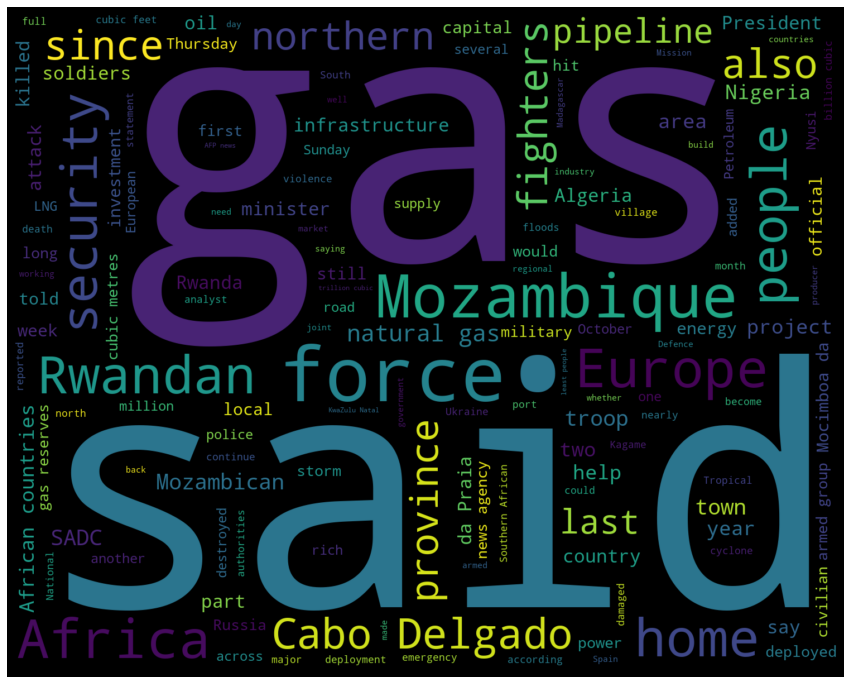

In [19]:
#Wordcloud to capture more insights about the article data with the most frequent words giving us the sentiment of all the articles
from wordcloud import WordCloud
from nltk.corpus import stopwords 
nltk.download('stopwords')
data=article_df
stop_words = stopwords.words('english')
stop = ["https", "co", "char","chars"] + list(stop_words)
wc = WordCloud(stopwords=stop, max_words=700, margin=10, background_color='black',
scale=3, relative_scaling = 0.4, width=500, height=400,
random_state=1).generate(' '.join(data['Content']))
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()